In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
from pathlib import Path
from tqdm.notebook import tqdm
import nibabel as nib
from PIL import Image
import cv2
import albumentations as A
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from sklearn.model_selection import train_test_split
import types

In [ ]:
# Tạo danh sách file
file_list = []
for dirname, _, filenames in os.walk('/...../input/liver-tumor-segmentation'):
    for filename in filenames:
        file_list.append((dirname, filename))
for dirname, _, filenames in os.walk('/....../input/liver-tumor-segmentation-part-2'):
    for filename in filenames:
        file_list.append((dirname, filename))

df_files = pd.DataFrame(file_list, columns=['dirname', 'filename'])
df_files = df_files.sort_values(by=['filename']).reset_index(drop=True)

# Map mask
df_files["mask_dirname"] = ""
df_files["mask_filename"] = ""
for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "../input/liver-tumor-segmentation/segmentations"

df_files = df_files[df_files.mask_filename != ''].reset_index(drop=True)
print(f"Số volume có mask: {len(df_files)}")

Số volume có mask: 131


In [ ]:
def read_nii(filepath):
    ct_scan = nib.load(filepath)
    array = ct_scan.get_fdata()
    array = np.rot90(np.array(array))  # xoay để hiển thị đúng
    return array

# Hàm apply liver window và chuyển sang uint8 để save JPG
def apply_liver_window(img, width=150, level=30):
    min_val = level - width // 2
    max_val = level + width // 2
    img = np.clip(img, min_val, max_val)
    img = (img - min_val) / (max_val - min_val)  # normalize [0,1]
    img = (img * 255).astype(np.uint8)
    return img

In [ ]:
### 4. Generate ảnh 2D (JPG + PNG mask)
GENERATE_JPG_FILES = True

if os.path.exists('train_images') and len(os.listdir('train_images')) > 500:
    print("Đã có data sẵn → Bỏ qua generate")
    GENERATE_JPG_FILES = False

if GENERATE_JPG_FILES:
    os.makedirs('train_images', exist_ok=True)
    os.makedirs('train_masks', exist_ok=True)

    selected_idx = random.sample(range(len(df_files)), min(20, len(df_files)))
    print(f"Đang generate từ {len(selected_idx)} volume (every 5 slice)...")

    for ii in tqdm(selected_idx):
        ct = read_nii(df_files.loc[ii, 'dirname'] + "/" + df_files.loc[ii, 'filename'])
        mask = read_nii(df_files.loc[ii, 'mask_dirname'] + "/" + df_files.loc[ii, 'mask_filename'])
        name = df_files.loc[ii, 'filename'].split('.')[0]
        dim = ct.shape[2]

        for sl in range(0, dim, 5):
            # Ảnh CT: apply window → grayscale → save JPG
            img_slice = ct[..., sl].astype(np.float32)
            img_windowed = apply_liver_window(img_slice)
            img_pil = Image.fromarray(img_windowed)
            img_pil.save(f"train_images/{name}_slice_{sl}.jpg")

            # Mask: lưu nguyên bản (uint8)
            mask_slice = mask[..., sl].astype(np.uint8)
            mask_pil = Image.fromarray(mask_slice)
            mask_pil.save(f"train_masks/{name}_slice_{sl}_mask.png")

print("Generate xong!")

Đang generate từ 20 volume (every 5 slice)...


  0%|          | 0/20 [00:00<?, ?it/s]

Generate xong!


In [ ]:
### 5. Thống kê số lượng ảnh và phân bố lớp
num_images = len(os.listdir('train_images'))
num_masks = len(os.listdir('train_masks'))
print(f"Số lượng ảnh 2D: {num_images}")
print(f"Số lượng mask: {num_masks}")

# Tỷ lệ foreground (liver + tumor)
fg_ratios = []
sample_masks = random.sample(os.listdir('train_masks'), min(300, num_masks))
for m in sample_masks:
    mask = np.array(Image.open(os.path.join('train_masks', m)))
    fg_ratios.append(np.sum(mask > 0) / mask.size)

print(f"Tỷ lệ pixel foreground trung bình: {np.mean(fg_ratios):.4f}")
print(f"Tỷ lệ pixel background trung bình: {1 - np.mean(fg_ratios):.4f}")

Số lượng ảnh 2D: 2093
Số lượng mask: 2093
Tỷ lệ pixel foreground trung bình: 0.0193
Tỷ lệ pixel background trung bình: 0.9807


In [ ]:
### 6. Chia tập dữ liệu Train/Val/Test theo volume
df_files['vol_id'] = df_files['filename'].str.extract(r'volume-(\d+)').astype(int)

train_vols, temp_vols = train_test_split(df_files['vol_id'].unique(), test_size=0.3, random_state=42)
val_vols, test_vols = train_test_split(temp_vols, test_size=0.5, random_state=42)

train_df = df_files[df_files['vol_id'].isin(train_vols)]
val_df   = df_files[df_files['vol_id'].isin(val_vols)]
test_df  = df_files[df_files['vol_id'].isin(test_vols)]

print(f"Train volumes: {len(train_vols)}, Val: {len(val_vols)}, Test: {len(test_vols)}")

Train volumes: 91, Val: 20, Test: 20


In [ ]:
import glob
import random

target_size = (128, 128)

# Augmentation chỉ cho train
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
])

# Lấy list tất cả file ảnh
image_files = sorted(glob.glob('train_images/*.jpg'))
mask_files = [f.replace('train_images', 'train_masks').replace('.jpg', '_mask.png') for f in image_files]

print(f"Tìm thấy {len(image_files)} cặp ảnh-mask")

# Shuffle và split random (70% train, 15% val, 15% test)
combined = list(zip(image_files, mask_files))
random.shuffle(combined)
image_files[:], mask_files[:] = zip(*combined)

n = len(image_files)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

train_imgs = image_files[:train_end]
train_masks = mask_files[:train_end]
val_imgs = image_files[train_end:val_end]
val_masks = mask_files[train_end:val_end]
test_imgs = image_files[val_end:]
test_masks = mask_files[val_end:]

def load_from_files(img_paths, mask_paths, augment=False):
    images, masks = [], []
    for img_path, mask_path in zip(img_paths, mask_paths):
        # Load ảnh CT (grayscale)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, target_size)
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=-1)

        # Load mask
        msk = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        msk = cv2.resize(msk, target_size)
        msk = (msk > 0).astype(np.float32)
        msk = np.expand_dims(msk, axis=-1)

        if augment:
            augmented = aug(image=img[..., 0], mask=msk[..., 0])
            img = np.expand_dims(augmented['image'], axis=-1)
            msk = np.expand_dims(augmented['mask'], axis=-1)

        images.append(img)
        masks.append(msk)
    return np.array(images), np.array(masks)

print("Đang load train (có augmentation)...")
X_train, y_train = load_from_files(train_imgs, train_masks, augment=True)
print("Đang load val...")
X_val, y_val = load_from_files(val_imgs, val_masks, augment=False)
print("Đang load test...")
X_test, y_test = load_from_files(test_imgs, test_masks, augment=False)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Tìm thấy 2093 cặp ảnh-mask
Đang load train (có augmentation)...
Đang load val...
Đang load test...
Train: (1465, 128, 128, 1), Val: (314, 128, 128, 1), Test: (314, 128, 128, 1)


In [ ]:
###  Xây dựng kiến trúc U-Net
def unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)

    # Decoder
    u4 = UpSampling2D((2, 2))(c3)
    u4 = Concatenate()([u4, c2])
    c4 = Conv2D(128, 3, activation='relu', padding='same')(u4)
    c4 = Conv2D(128, 3, activation='relu', padding='same')(c4)

    u5 = UpSampling2D((2, 2))(c4)
    u5 = Concatenate()([u5, c1])
    c5 = Conv2D(64, 3, activation='relu', padding='same')(u5)
    c5 = Conv2D(64, 3, activation='relu', padding='same')(c5)

    outputs = Conv2D(1, 1, activation='sigmoid')(c5)

    return Model(inputs, outputs)

unet = unet_model()
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet.summary()

I0000 00:00:1770375897.795839      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770375897.802614      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 192)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │    110,656 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_8[0][0]  

 Total params: 1,881,985 (7.18 MB)

 Trainable params: 1,881,985 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
###  Huấn luyện U-Net
history = unet.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)

Epoch 1/20


I0000 00:00:1770375935.220054     185 service.cc:152] XLA service 0x7d8144009940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770375935.220089     185 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1770375935.220092     185 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1770375935.940438     185 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-02-06 11:05:42.534496: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-06 11:05:42.833815: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-06 11:05:45.054289: E external/local_xl

 1/92 ━━━━━━━━━━━━━━━━━━━━ 35:24 23s/step - accuracy: 0.6895 - loss: 0.6927

I0000 00:00:1770375955.561227     185 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9606 - loss: 0.2310

2026-02-06 11:06:09.217082: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-06 11:06:09.486895: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-06 11:06:11.626917: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-06 11:06:11.928028: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-06 11:06:13.356490: E external/local_xla/xla/stream_

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9607 - loss: 0.2297

2026-02-06 11:06:29.224089: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-06 11:06:29.495644: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 392ms/step - accuracy: 0.9609 - loss: 0.2285 - val_accuracy: 0.9804 - val_loss: 0.0459
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9811 - loss: 0.0476 - val_accuracy: 0.9879 - val_loss: 0.0330
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.9861 - loss: 0.0368 - val_accuracy: 0.9892 - val_loss: 0.0324
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 0.9871 - loss: 0.0352 - val_accuracy: 0.9883 - val_loss: 0.0318
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 0.9872 - loss: 0.0335 - val_accuracy: 0.9900 - val_loss: 0.0295
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.9873 - loss: 0.0350 - val_accuracy: 0.9895 - val_loss: 0.0281
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 0.9885 - loss: 0.0311 - val_accuracy: 0.9909 - val_loss: 0.0273
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 0.9885 - loss: 0.0306 - val_accuracy: 0.990

In [ ]:
### Đánh giá trên tập Test và tính các chỉ số y tế
loss, acc = unet.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

y_pred = (unet.predict(X_test) > 0.5).astype(np.float32)

def dice(y_true, y_pred):
    inter = np.sum(y_true * y_pred)
    return (2 * inter + 1) / (np.sum(y_true) + np.sum(y_pred) + 1)

def iou(y_true, y_pred):
    inter = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - inter
    return (inter + 1) / (union + 1)

def sensitivity(y_true, y_pred):
    tp = np.sum(y_true * y_pred)
    fn = np.sum(y_true * (1 - y_pred))
    return tp / (tp + fn + 1e-7)

def specificity(y_true, y_pred):
    tn = np.sum((1 - y_true) * (1 - y_pred))
    fp = np.sum((1 - y_true) * y_pred)
    return tn / (tn + fp + 1e-7)

dice_scores = [dice(y, p) for y, p in zip(y_test, y_pred)]

print(f"Dice Coefficient: {np.mean(dice_scores):.4f}")
print(f"IoU: {np.mean([iou(y, p) for y, p in zip(y_test, y_pred)]):.4f}")
print(f"Sensitivity: {np.mean([sensitivity(y, p) for y, p in zip(y_test, y_pred)]):.4f}")
print(f"Specificity: {np.mean([specificity(y, p) for y, p in zip(y_test, y_pred)]):.4f}")


2026-02-06 11:11:22.131314: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng12{k11=2} for conv %cudnn-conv-bias-activation.41 = (f32[32,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,192,128,128]{3,2,1,0} %bitcast.740, f32[64,192,3,3]{3,2,1,0} %bitcast.747, f32[64]{0} %bitcast.749), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/conv2d_8_1/convolution" source_file="/usr/local/lib/python3.12/dist-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2026-02-06 11:11:22.243714: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.112498263s
Trying algorithm 

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9956 - loss: 0.0137

2026-02-06 11:11:29.602173: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-06 11:11:29.903461: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9956 - loss: 0.0138
Test Loss: 0.0143, Test Accuracy: 0.9953
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step
Dice Coefficient: 0.8373
IoU: 0.8170
Sensitivity: 0.2149
Specificity: 0.9980


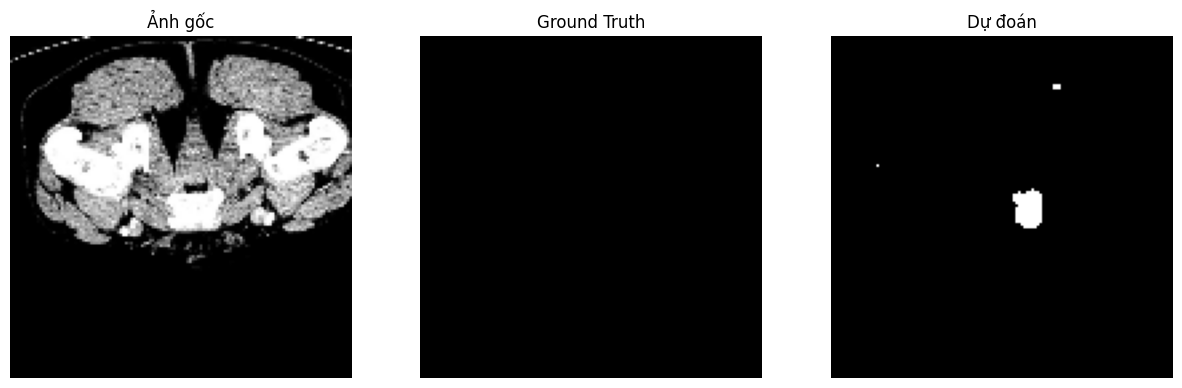

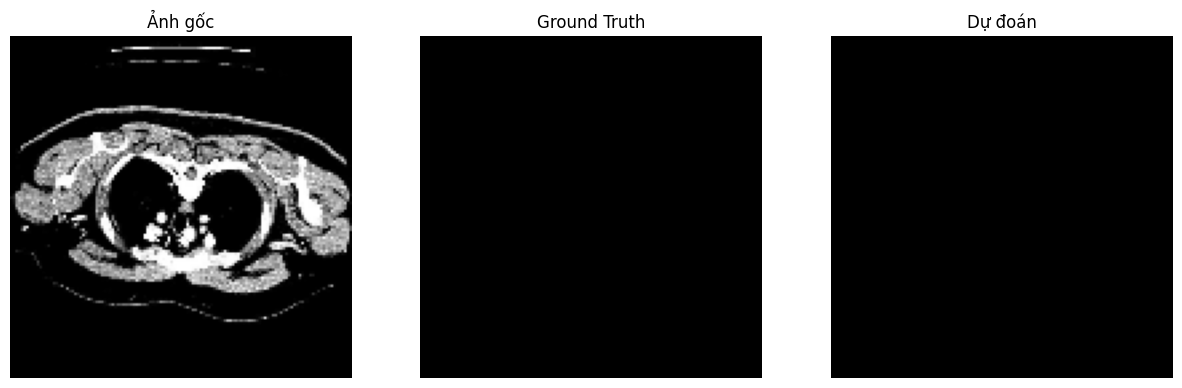

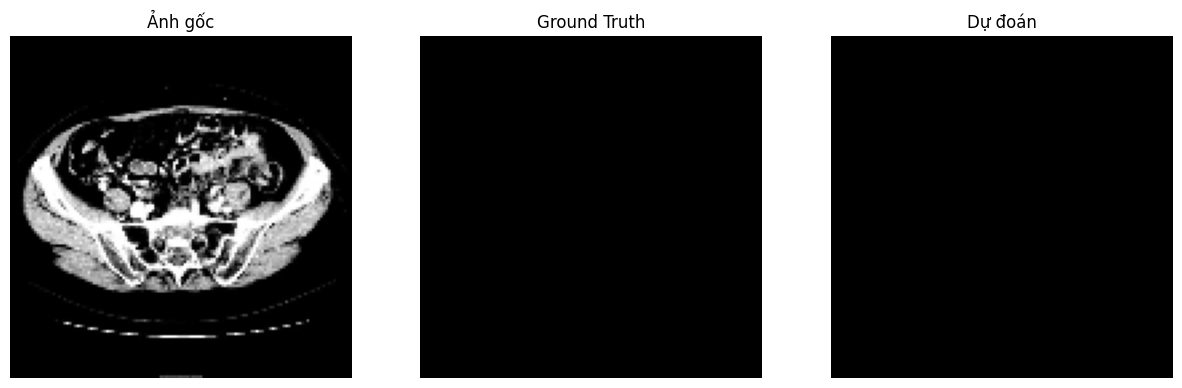

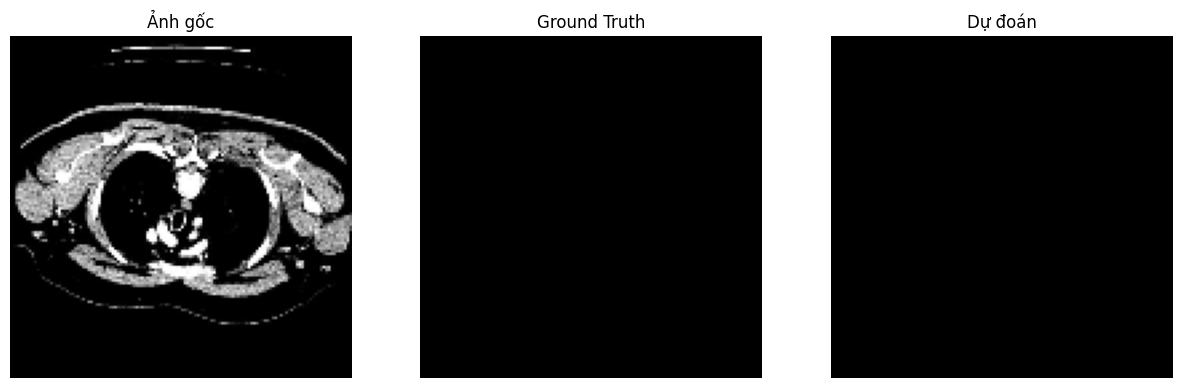

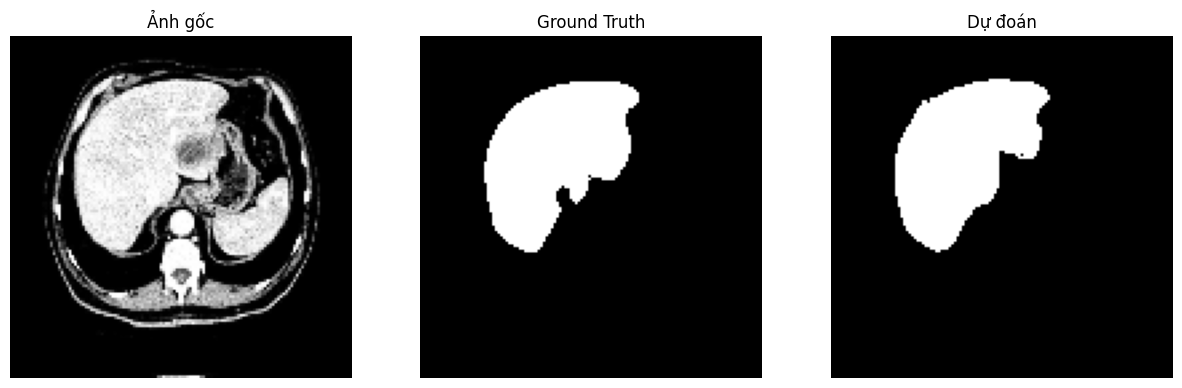

Số ca dự đoán kém (Dice < 0.5): 48


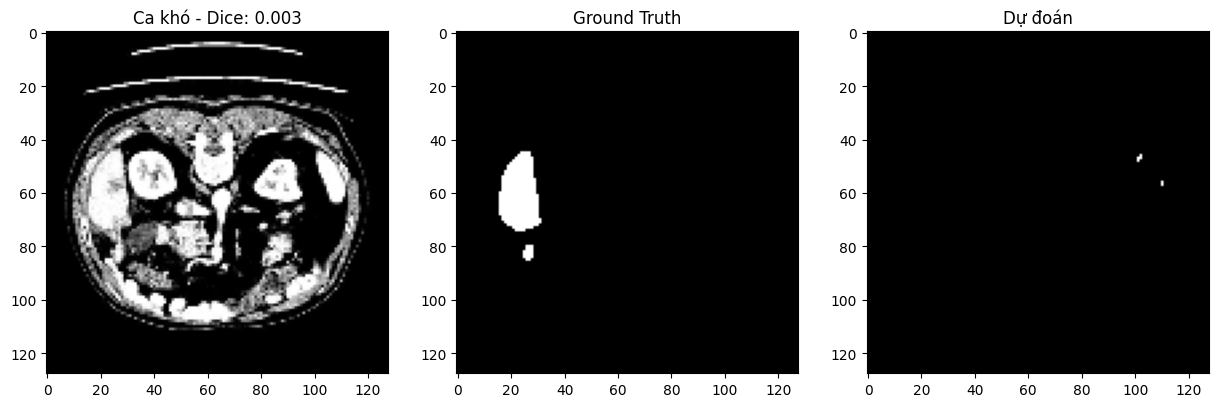

Lý do đoán sai thường gặp: khối u rất nhỏ, biên giới mờ, hoặc slice ít thông tin gan.


In [ ]:
### Visualize kết quả và phân tích sai số
# Visualize ngẫu nhiên 5 mẫu
for i in random.sample(range(len(X_test)), 5):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    plt.title('Ảnh gốc')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(y_test[i].squeeze(), cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(y_pred[i].squeeze(), cmap='gray')
    plt.title('Dự đoán')
    plt.axis('off')
    plt.show()

# Error analysis: các ca Dice thấp
low_dice_idx = np.where(np.array(dice_scores) < 0.5)[0]
print(f"Số ca dự đoán kém (Dice < 0.5): {len(low_dice_idx)}")

if len(low_dice_idx) > 0:
    i = low_dice_idx[0]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    plt.title(f'Ca khó - Dice: {dice_scores[i]:.3f}')
    plt.subplot(1, 3, 2)
    plt.imshow(y_test[i].squeeze(), cmap='gray')
    plt.title('Ground Truth')
    plt.subplot(1, 3, 3)
    plt.imshow(y_pred[i].squeeze(), cmap='gray')
    plt.title('Dự đoán')
    plt.show()

print("Lý do đoán sai thường gặp: khối u rất nhỏ, biên giới mờ, hoặc slice ít thông tin gan.")